# Анализ игровых рынков

Заказчик – интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. 

Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Данные до 2016 года. Представим, что сейчас декабрь 2016 г., и планируется кампания на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируются ли продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

# Шаг 1. Загрузка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st
import re

In [2]:
games = pd.read_csv('games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Шаг 2. Подготовка данных.

In [4]:
games.columns = games.columns.str.lower()
games = games.rename(columns={'year_of_release': 'year'})
games.head()

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Суммируем продажи по всем регионам и получим общие продажи.

In [5]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Значения в user_score надо привести к float, а год выхода – это, по идее, datetime. Однако нам не нужны операции с датами, и year можно не конвертировать.

"tbd" в столбцах с рейтингом означает to be determined, т.е. рейтинга пока нет. Это может произойти из-за того что игра новая или не очень популярная. В рамках нашего исследования это равносильно NaN, так что столбик user_score спокойно приводим к float, а данные о строчках с tbd сохраняем в отдельную переменную, чтобы проверить гипотезу о непопулярности игр с tbd в оценке.

In [6]:
tbd_games = games.loc[games['user_score']=='tbd']

In [7]:
games['user_score'] = pd.to_numeric(games['user_score'],errors='coerce')

Теперь посмотрим на средние продажи у игр без рейтинга и у игр с рейтингом, сравним эти показатели с показателями по играм с tbd.

In [12]:
print('Средние продажи')
print("Игр с оценкой: {:.2f}\nИгр без оценки: {:.2f}\nИгр с tbd: {:.2f}".format(
    games.loc[games['user_score'].notna()]['total_sales'].mean(),
    games.loc[games['user_score'].isna()]['total_sales'].mean(),
    tbd_games['total_sales'].mean()))

Средние продажи
Игр с оценкой: 0.74
Игр без оценки: 0.36
Игр с tbd: 0.19


Действительно, выручка игр с tbd в среднем очень маленькая (если сравнивать с выручкой игр с оценкой). Такие игры, и правда, (пока что) не пользуются большой популярностью.

In [13]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  object 
 1   platform      16715 non-null  object 
 2   year          16446 non-null  float64
 3   genre         16713 non-null  object 
 4   na_sales      16715 non-null  float64
 5   eu_sales      16715 non-null  float64
 6   jp_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  8137 non-null   float64
 9   user_score    7590 non-null   float64
 10  rating        9949 non-null   object 
 11  total_sales   16715 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


Пропуски есть в колонках name, year, genre, critic_score, user_score и rating. Появились они, видимо, у непопулярных игр. Заполнять пропуски в колонках с оценками средними значениями здесь не стоит – их слишком много (картина будет искажена), а также далее нам будут нужны данные о конкретных играх. Лучше оставить всё так, как есть.

Пропуски в genre, year и rating нельзя заполнить тем более – ни среднее, ни медиана, ни категоризация тут не помогут.

Подозрительная вещь – пропуски в name. Посмотрим на строчки с ними.

In [14]:
games.query('name.isna()')

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


Это старые игры без жанра с маленькими продажами. Возможно, у них, и правда, не было названия.

NaN-игр всего две, так что можно оставить их в таблице – они ничего не испортят.

# Шаг 3. Исследовательский анализ данных.

## Распределение количества игр по годам

Количество игр по годам для наглядности изобразим на графике:

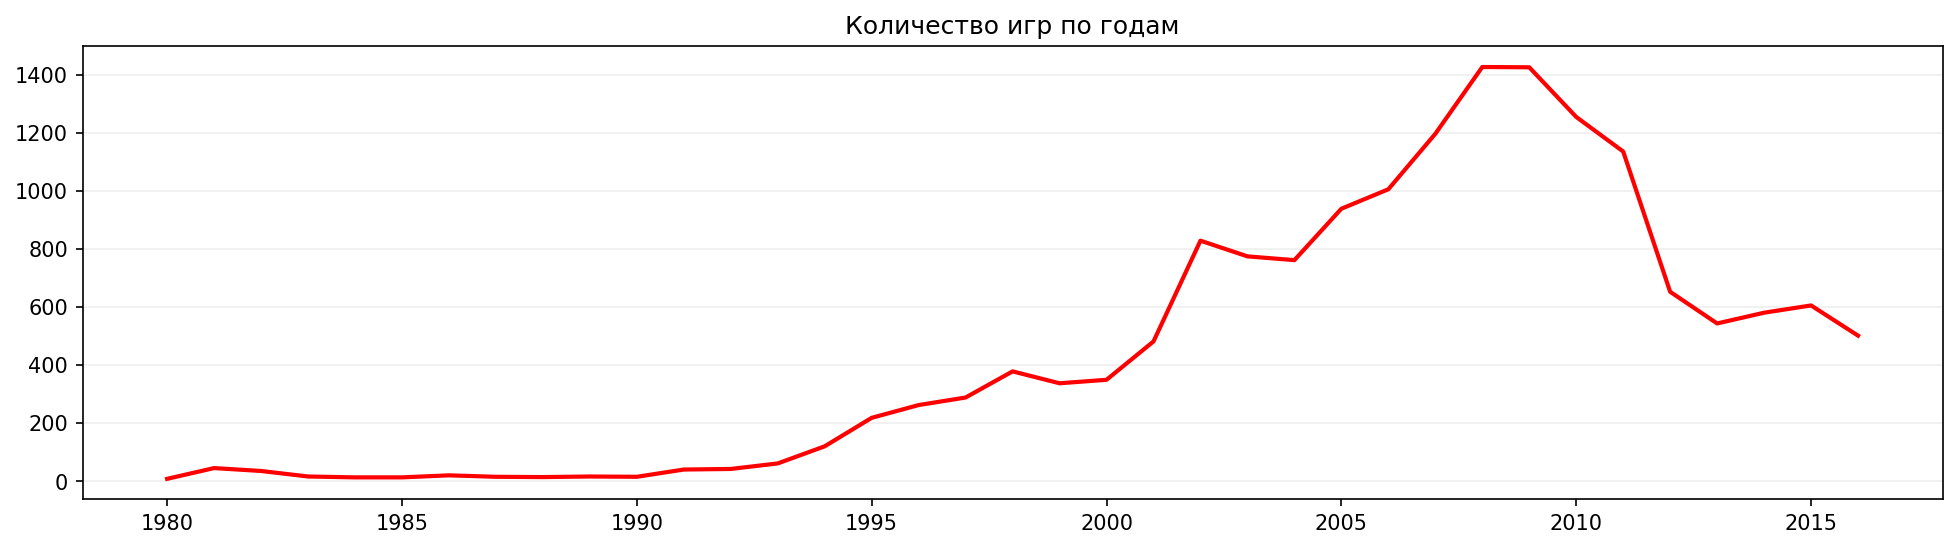

In [23]:
plt.figure(figsize=(16,4),dpi=150)
plt.plot(games.groupby('year')['total_sales'].count(), linewidth=2, color='red')
plt.title('Количество игр по годам')
plt.grid(axis='y',alpha=0.2)

Судя по этим данным, пик игропроизводства пришёлся на 2008-2010 годы. Для определения успешности современной игры нам нужны данные, которые незначительно отличаются от данных по текущему году. Судя по графику выше, лучше будет взять всё, начиная с ~2011 года – бум 2008-2010 гг прошёл, график почти выровнялся, и данных при этом будет достаточно много.

Посмотрим на график по играм 2011-2016 годов:

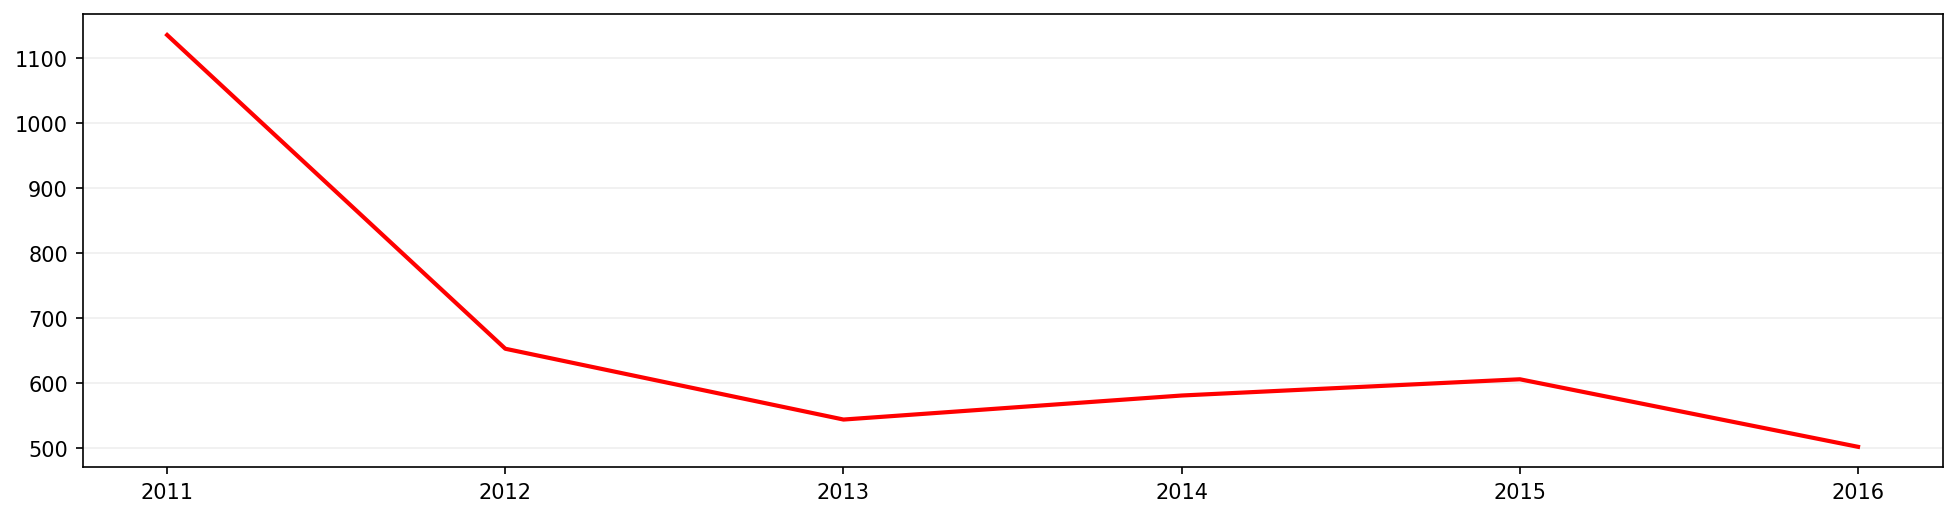

In [26]:
plt.figure(figsize=(16,4),dpi=150)
plt.plot(games.query('year >= 2011').groupby('year')['total_sales'].count(), linewidth=2, color='red')
plt.grid(axis='y',alpha=0.2)

Сохраним данные об актуальных играх в отдельный список:

In [27]:
modern_games = games.query('year >= 2011').copy()

## Самые успешные игровые платформы и их цикл жизни

Составим список уже мертвых платформ, для того чтобы впоследствии найти типичный цикл жизни консолей.

In [28]:
dead_platforms = list(games.groupby('platform')['year'].max().reset_index().query('year != 2016')['platform'])

Создадим таблицу продолжительности жизни платформ:

In [31]:
platform_life = games.loc[games['platform'].isin(dead_platforms)].groupby(
    ['platform','year'])['total_sales'].sum().reset_index().groupby(
    'platform')['year'].count().reset_index().query('platform != "PC" & year > 3')

В таблицу включены только платформы, прожившие дольше трёх лет, то есть, более-менее успешные.

Консоли-долгожители:


In [32]:
platform_life.sort_values('year', ascending=False).head(10)

,platform,year
4,GB,13
10,NES,12
14,PS2,12
15,PSP,12
3,DS,11
0,2600,10
13,PS,10
18,SNES,10
21,XB,9
5,GBA,8


Посчитаем медиану по этой таблице.

In [34]:
platform_life['year'].median()

9.5

Медианная продолжительность жизни платформы – 9.5 лет. Так что если консоль уже старше 9.5 лет, вкладываться в рекламную компанию по ней уже не стоит – вероятно, она скоро умрёт.


Теперь посмотрим на самые успешные из мёртвых платформ:


In [35]:
games.loc[games['platform'].isin(dead_platforms)].groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)

platform
PS2     1255.77
DS       806.12
PS       730.86
GBA      317.85
PSP      294.05
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
Name: total_sales, dtype: float64

И для дальнейшего анализа цикла жизни платформ возьмём PS2, Nintendo DS, PSP, XBox и Game Boy Advance – они входят в десятку долгожителей, десятку самых успешных консолей и при этом они младше пятнадцати лет.

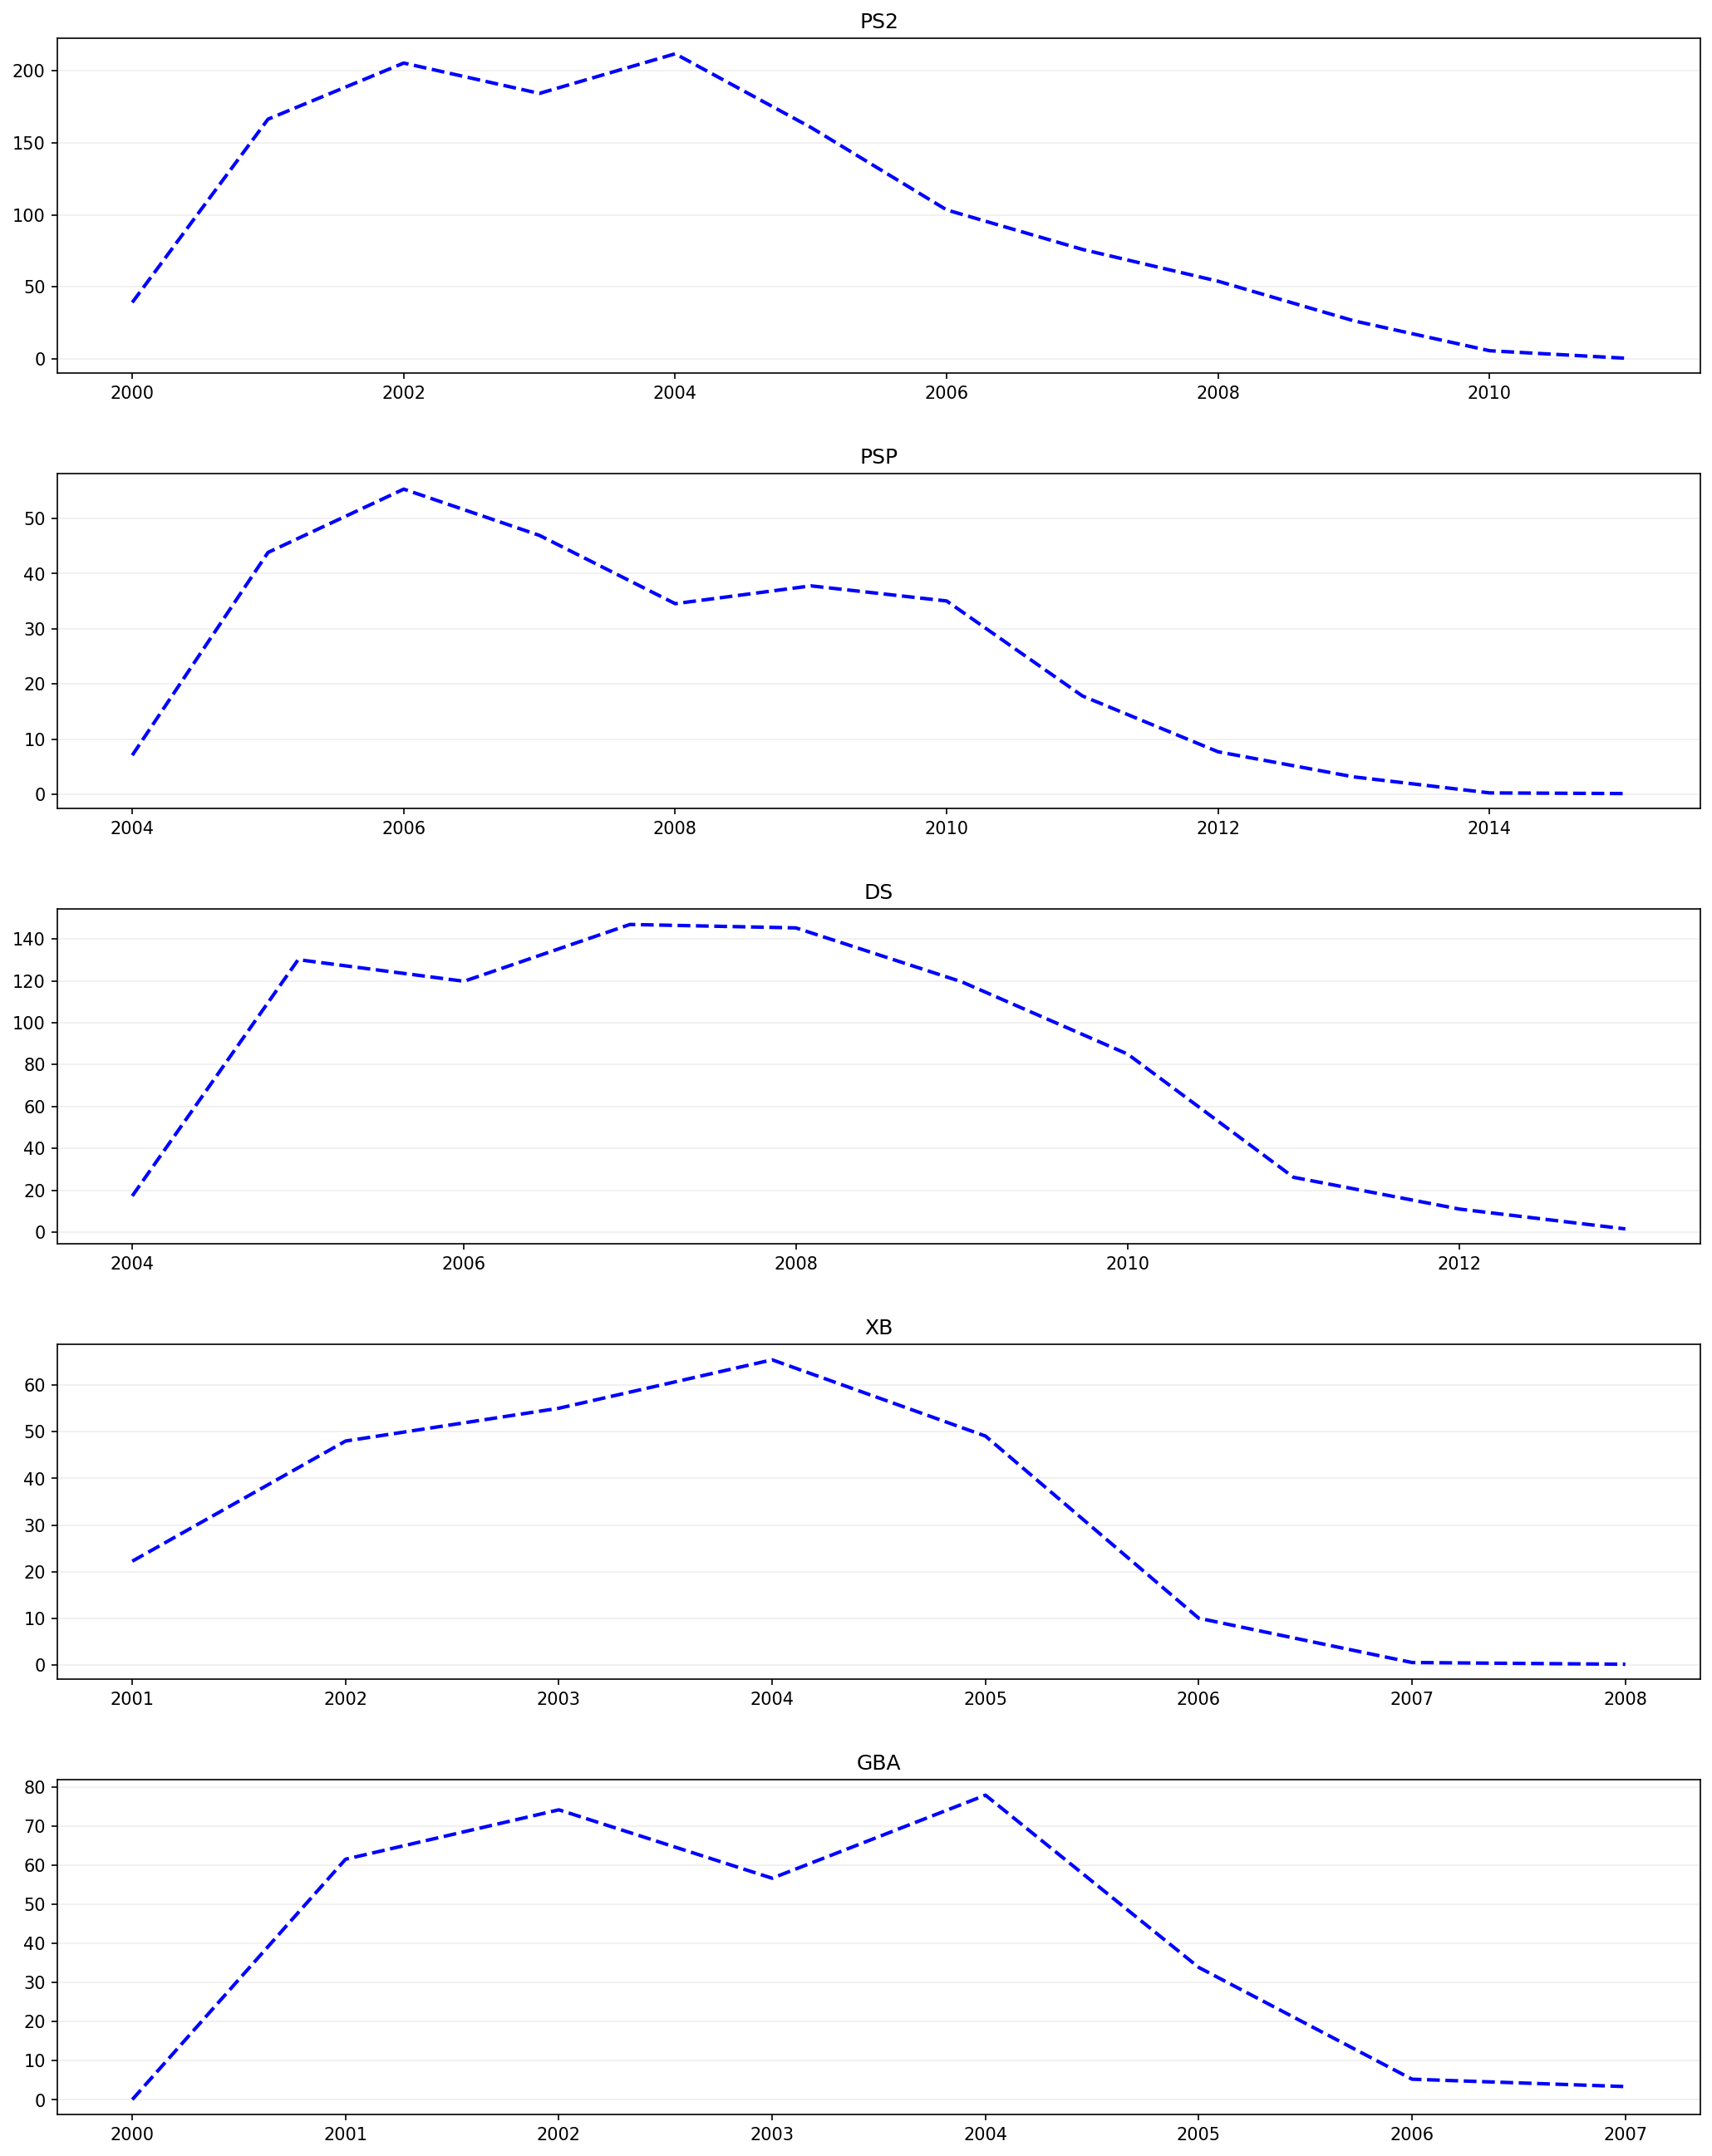

In [59]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(17,17),dpi=150)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.3)

queries = ['platform == "PS2"', 
           'platform == "PSP"', 
           'platform == "DS" and year >= 2004',
           'platform == "XB" and year >= 2001',
           'platform == "GBA"']

for ax, q in zip(axes.flatten(), queries):
    ax.plot(games.query(q).groupby('year')['total_sales'].sum(), 'b--', linewidth=2)
    ax.set_title(re.findall('"([^"]*)"',q)[0])
    ax.grid(axis='y',alpha=0.2)

plt.show()

По графикам видно, что платформы обычно достигают первого пика во второй-третий год после выпуска.

Второй пик, судя по всему, появляется благодаря выпуску обновлённых версий консолей, например Nintendo DS Lite или PlayStation 2 Slim.

Следовательно, самое удачное время для рекламных кампаний игр платформы – второй и третий годы её жизни, а популярность платформы значительно падает примерно в 6 год её жизни.

<b><i>Далее для анализа берём данные с 2011 по 2016.

## Анализ актуальных платформ

In [60]:
relevant_platforms = games.query('year >= 2011').groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(8)
relevant_platforms

platform
PS3     445.57
X360    380.38
PS4     314.14
3DS     257.81
XOne    159.32
PC       97.68
Wii      95.02
WiiU     82.19
Name: total_sales, dtype: float64

Лидер продаж за последние 5 лет – PlayStation 3, за ней идут XBox 360 и PS4, которая в 2016 году должна быть на пике прибыльности (это её третий год на рынке).


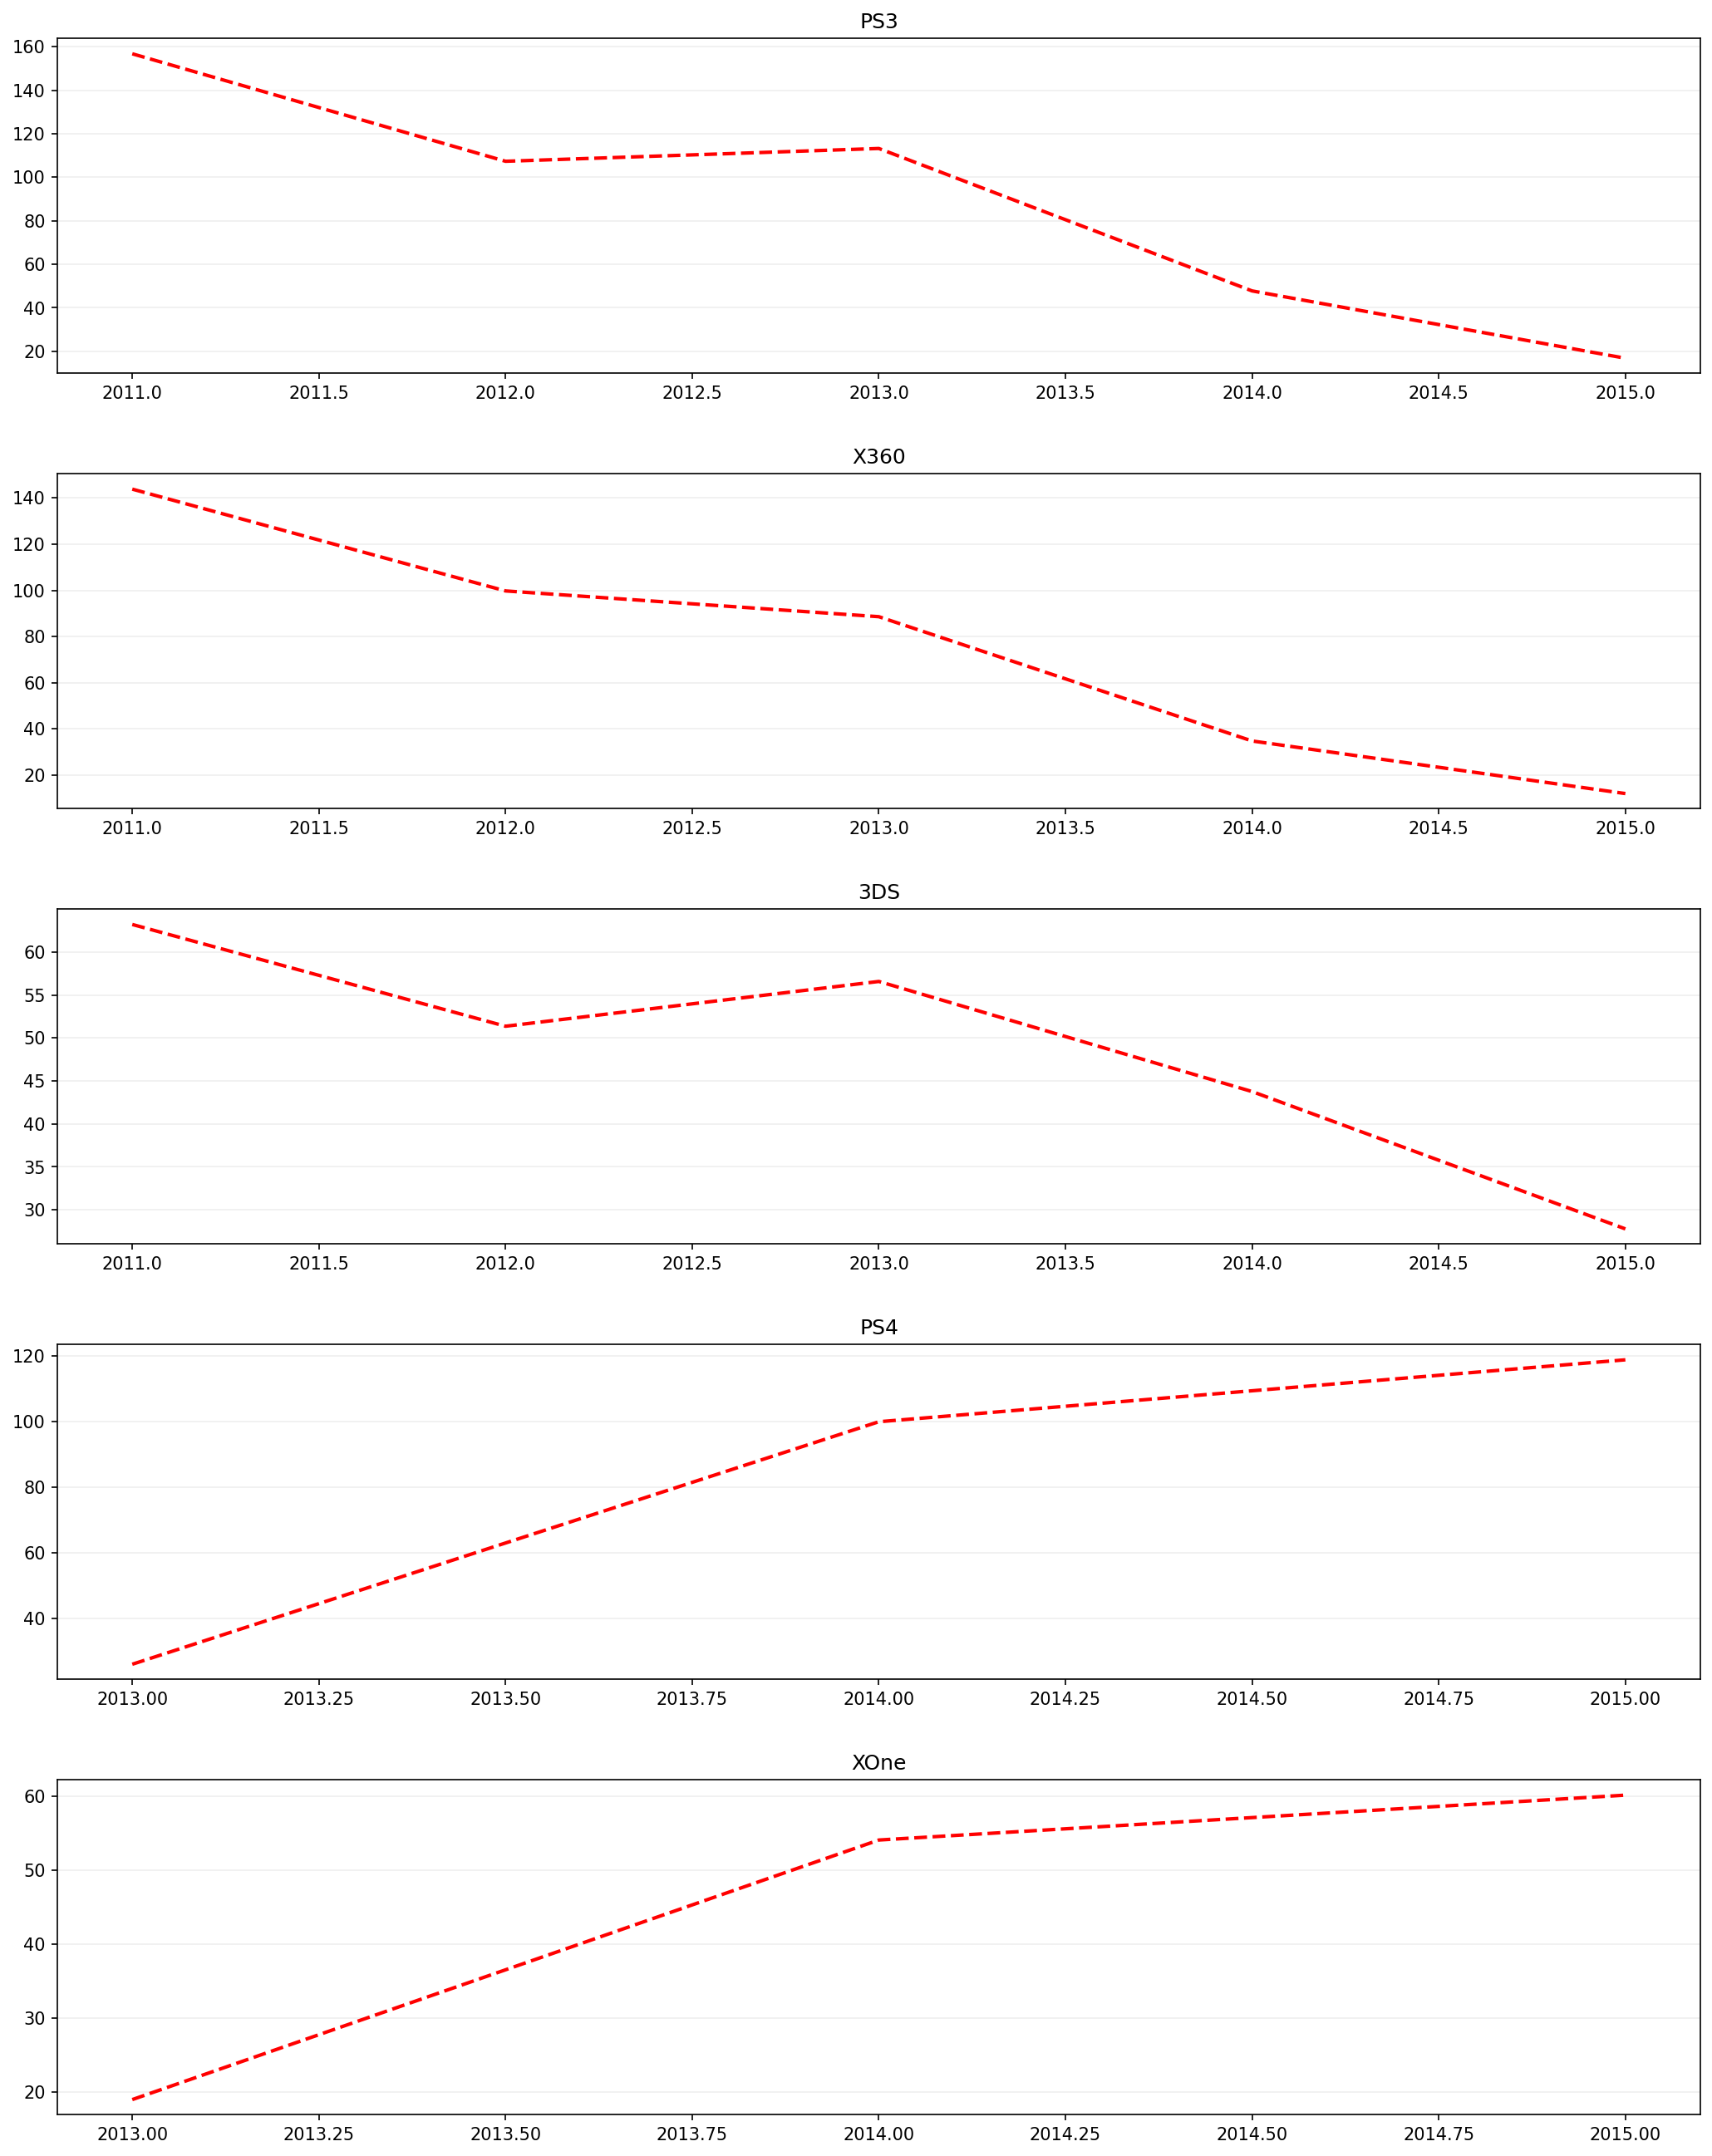

In [61]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(17,17),dpi=150)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.3)

queries = ['platform == "PS3" and 2011 <= year <= 2015', 
           'platform == "X360" and 2011 <= year <= 2015', 
           'platform == "3DS" and 2011 <= year <= 2015',
           'platform == "PS4" and 2011 <= year <= 2015',
           'platform == "XOne" and 2011 <= year <= 2015']

for ax, q in zip(axes.flatten(), queries):
    ax.plot(games.query(q).groupby('year')['total_sales'].sum(), 'r--', linewidth=2)
    ax.set_title(re.findall('"([^"]*)"',q)[0])
    ax.grid(axis='y',alpha=0.2)

plt.show()

Динамика у PS3, X360 и 3DS очень схожая – они уже доживают своё и продажи падают, что, в принципе, совпадает с вычисленным ранее сроком жизни платформы – 9.5 лет (PS3 и X360 выпущены в 2006). Делать на них ставку точно не стоит.

XBox One и PlayStation 4 растут и их графики крайне схожи по форме. Различается лишь прибыль с игр.

Как я уже говорил, эти платформы будут находится на пике популярности в этом и следующем годах.

## Ящик с усами и играми

Посмотрим на продажи по платформам, используя ящик с усами.

Для начала сделаем отдельный список для актуальных платформ.


In [63]:
platforms_list = list(relevant_platforms.index)
platforms_list

['PS3', 'X360', 'PS4', '3DS', 'XOne', 'PC', 'Wii', 'WiiU']

Соберём данные о продажах в отдельную переменную:

In [66]:
data_to_plot = [games.query(f'platform == @platforms_list[{i}]')['total_sales'] for i in range(
    len(platforms_list))]

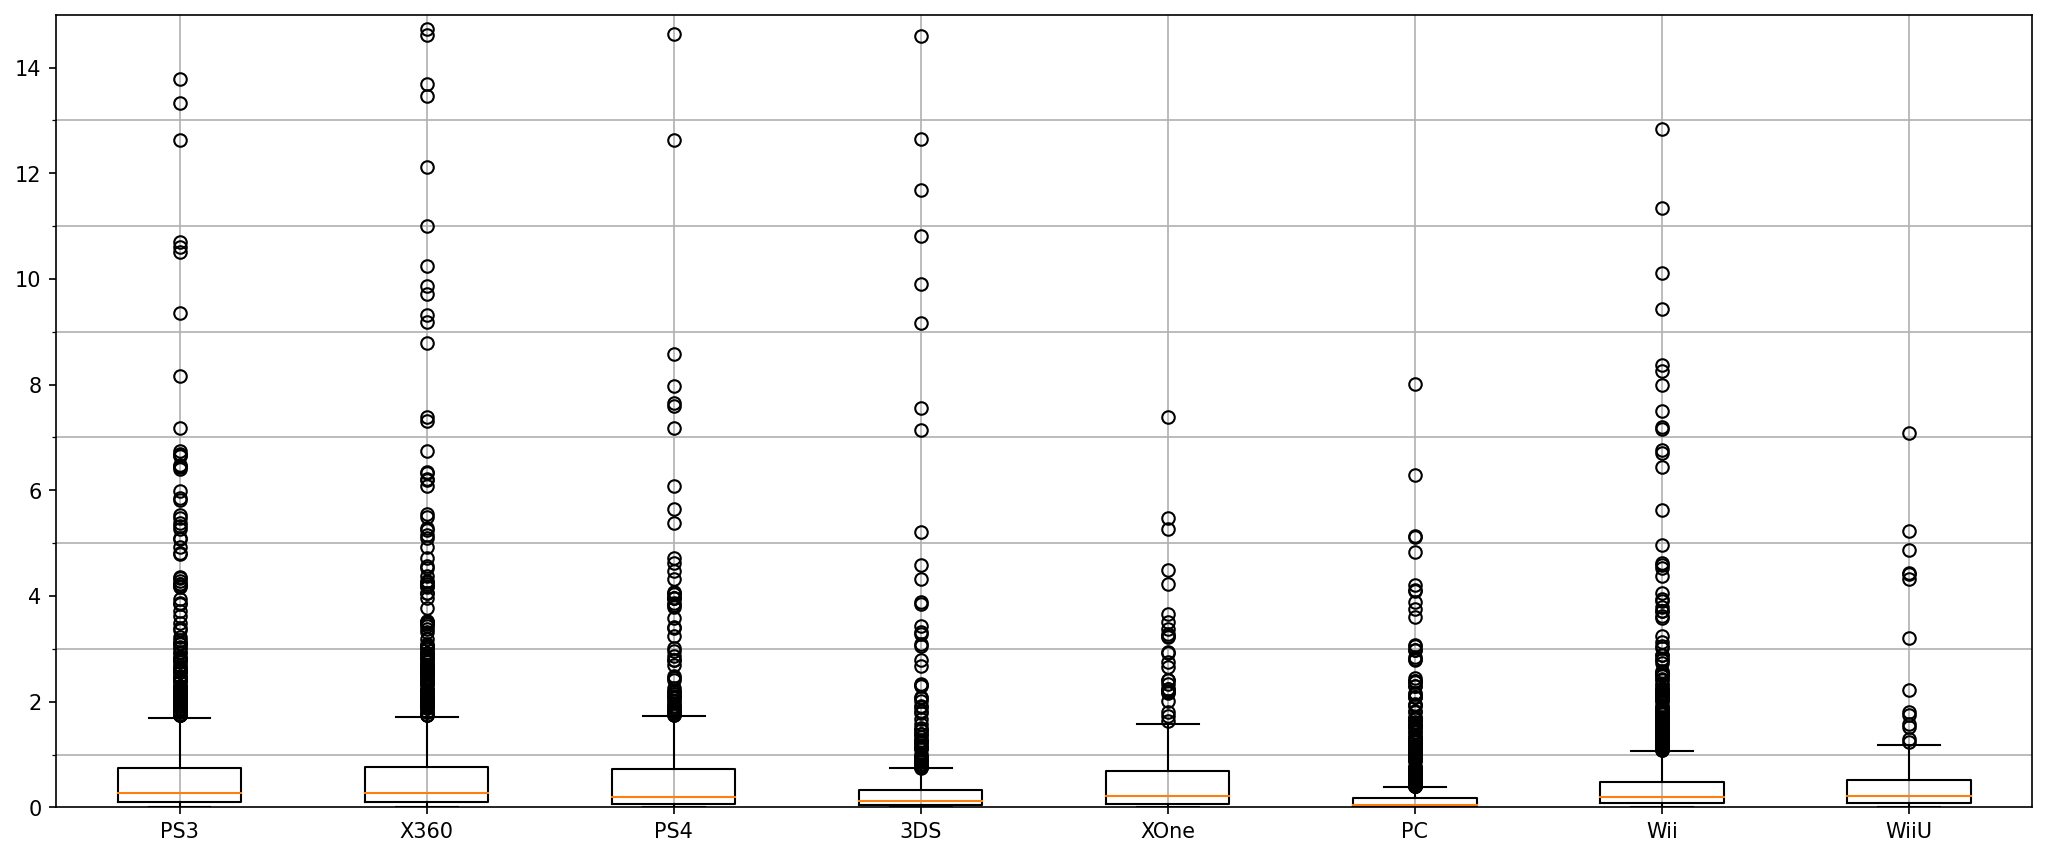

In [73]:
fig = plt.figure(1, figsize=(17, 7), dpi=150)
ax = fig.add_subplot(111)
plt.ylim(0,15)
major_ticks = np.arange(0, 15, 2)
minor_ticks = np.arange(0, 15, 1)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')

ax.boxplot(data_to_plot)

ax.set_xticklabels([x for x in platforms_list])
ax.grid(axis='y',alpha=0.2)

plt.show()

Продажи игр для PS3, PS4, X360 и XOne примерно одинаковые. Игры для консолей Nintendo продаются значительно хуже.

Особенно выделяется PC – игры для этой платформы продаются совсем плохо. Думаю, что отчасти это происходит из-за пиратства, а отчасти – из-за более низких цен.


## Оценки

Создадим датафрейм с данными по оценкам пользователей:

In [74]:
stats_user_score = modern_games.query(
    'user_score.notna() & platform == "PS3"').groupby(
    'year')['total_sales'].count().reset_index().merge(
    modern_games.query('user_score.isna() & platform == "PS3"').groupby(
        'year')['total_sales'].count().reset_index(), on='year')

stats_user_score['year'] = stats_user_score['year'].astype(int)
stats_user_score = stats_user_score.rename(columns={
    'total_sales_x':'with score', 
    'total_sales_y':'without score'})

С данными по оценкам критиков:

In [76]:
stats_critic_score = modern_games.query(
    'critic_score.notna() & platform == "PS3"').groupby(
    'year')['total_sales'].count().reset_index().merge(
    modern_games.query('critic_score.isna() & platform == "PS3"').groupby(
        'year')['total_sales'].count().reset_index(), on='year')

stats_critic_score['year'] = stats_critic_score['year'].astype(int)
stats_critic_score = stats_critic_score.rename(columns={
    'total_sales_x':'with score', 
    'total_sales_y':'without score'})

И объединим их в общий датасет scores_stats

In [77]:
scores_stats = games.query('platform == "PS3"').groupby('name')['critic_score'].mean().reset_index().merge(
    games.query('platform == "PS3"').groupby('name')['user_score'].mean().reset_index(), on='name', how='outer').merge(
    games.query('platform == "PS3"')[['name','total_sales']], on='name', how='outer')

Построим график и посмотрим, как менялось количество игр с отзывами и без.


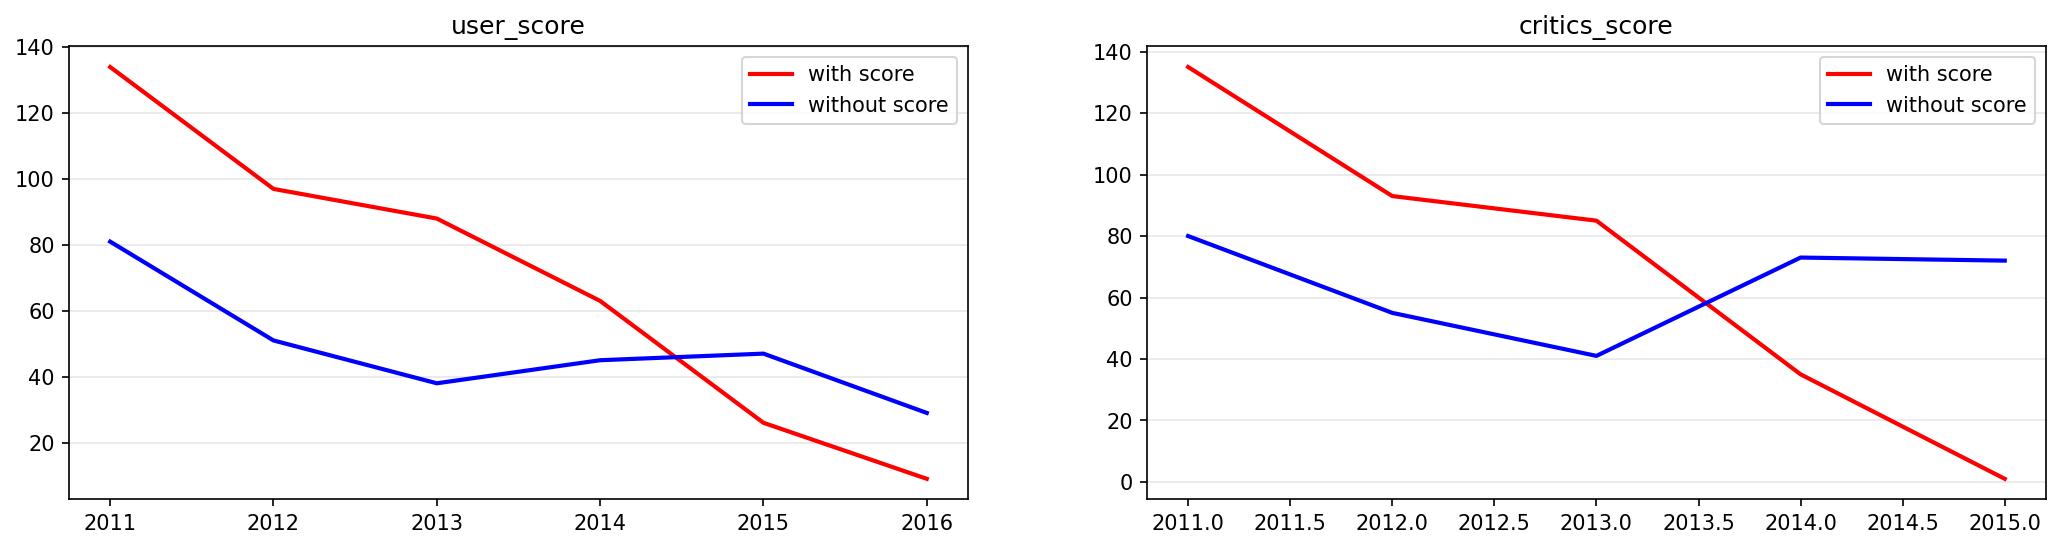

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4),dpi=150)
ax0, ax1 = axes.flatten()

ax0.plot(stats_user_score.set_index('year')['with score'], 'r', linewidth=2, label='with score')
ax0.plot(stats_user_score.set_index('year')['without score'], 'b', linewidth=2, label='without score')
ax0.set_title('user_score')
ax0.grid(axis='y',alpha=0.3)
ax0.legend()

ax1.plot(stats_critic_score.set_index('year')['with score'], 'r', linewidth=2, label='with score')
ax1.plot(stats_critic_score.set_index('year')['without score'], 'b', linewidth=2, label='without score')
ax1.set_title('critics_score')
ax1.grid(axis='y',alpha=0.3)
ax1.legend()

plt.show()

В 2014 году количество игр без отзывов пользователей превысило количество игр с отзывами. В 2013 то же самое произошло с отзывами критиков.

Есть ли корреляция между оценками пользователей и критиков?


<AxesSubplot:xlabel='critic_score', ylabel='user_score'>

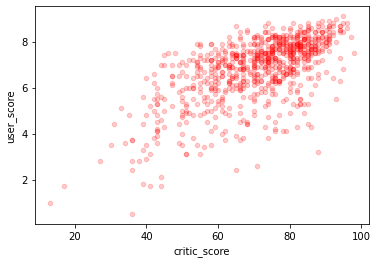

In [83]:
scores_stats.plot(
    x='critic_score',
    y='user_score', 
    kind='scatter', 
    alpha=0.2, color='red')

Положительная корреляция между оценками пользователей и оценками критиков заметна.

Теперь посмотрим, коррелируют ли оценки критиков/пользователей с общими продажами игры.

In [85]:
scores_stats['critic_score'].corr(scores_stats['total_sales'])

0.43243156856420567

In [86]:
scores_stats['user_score'].corr(scores_stats['total_sales'])

0.12669133936341698

Рейтинг пользователей практически не влияет на продажи игры (чтобы написать отзыв, нужно сначала купить игру), а средняя корреляция продаж и рейтинга критиков присутствует.

Похоже, что продажи зависят не от качества игры, а от успешности рекламы. Этим можно объяснить меньшие объёмы продаж на консолях Nintendo – вполне вероятно, что многие из игр на их платформах эксклюзивны и в их рекламу меньше вкладываются.

## Самые продаваемые игры

Теперь посмотрим на самые продаваемые игры за последние пять лет

In [87]:
sales_stats = modern_games.groupby('name')['total_sales'].sum().sort_values(ascending=False).head(20)

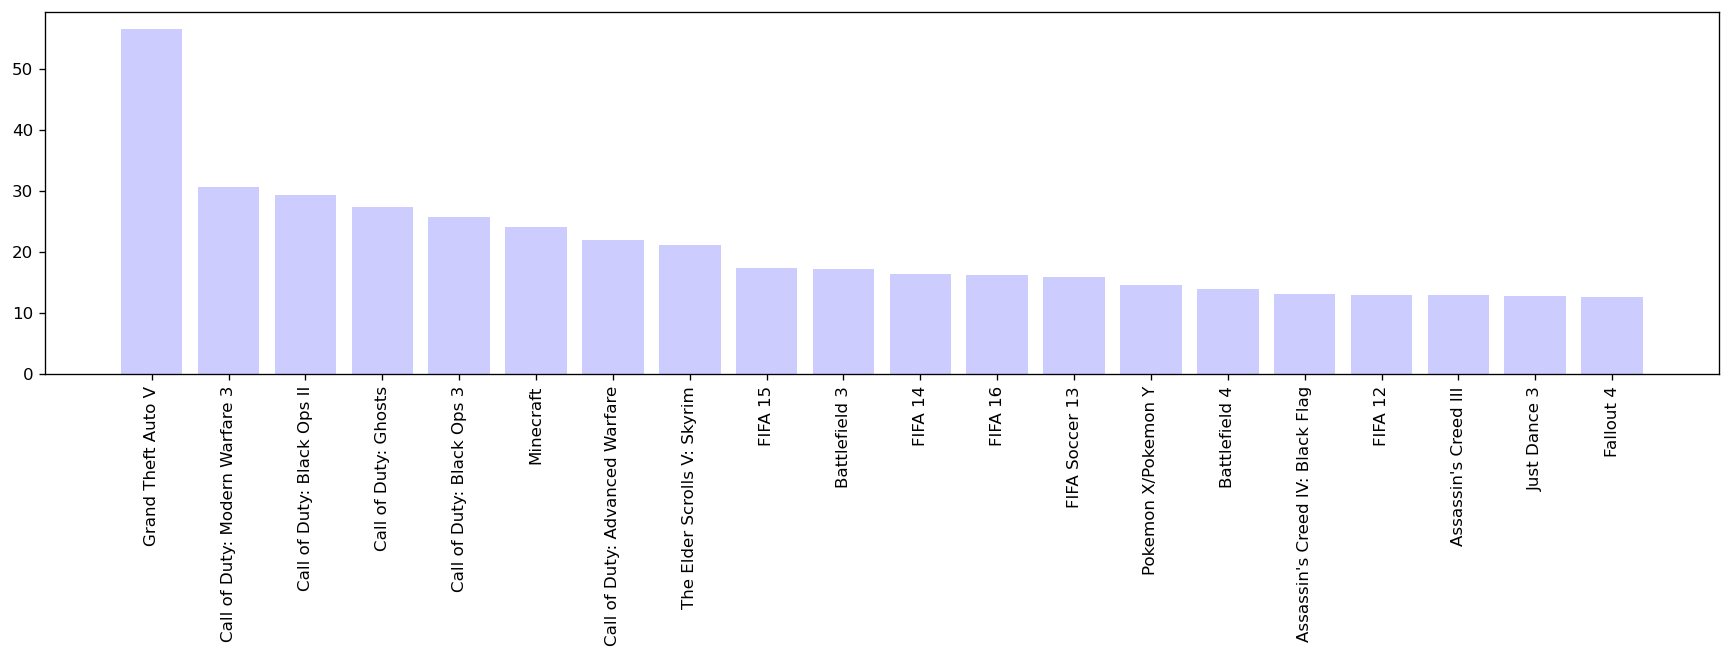

In [89]:
plt.figure(figsize=(18,4),dpi=120)
plt.bar(sales_stats.index, sales_stats.values, color='blue', alpha=0.2)
plt.xticks(rotation='vertical')
plt.show()

## Самые популярные жанры

Так как игры, выпускаемые на нескольких платформах, дублируются в таблице, нужно сначала избавиться от дубликатов и только потом применять группироовку по жанру.

In [90]:
genre_stats = modern_games.drop_duplicates(
    subset ='name').groupby('genre')['total_sales'].count().sort_values(ascending=False)

<BarContainer object of 12 artists>

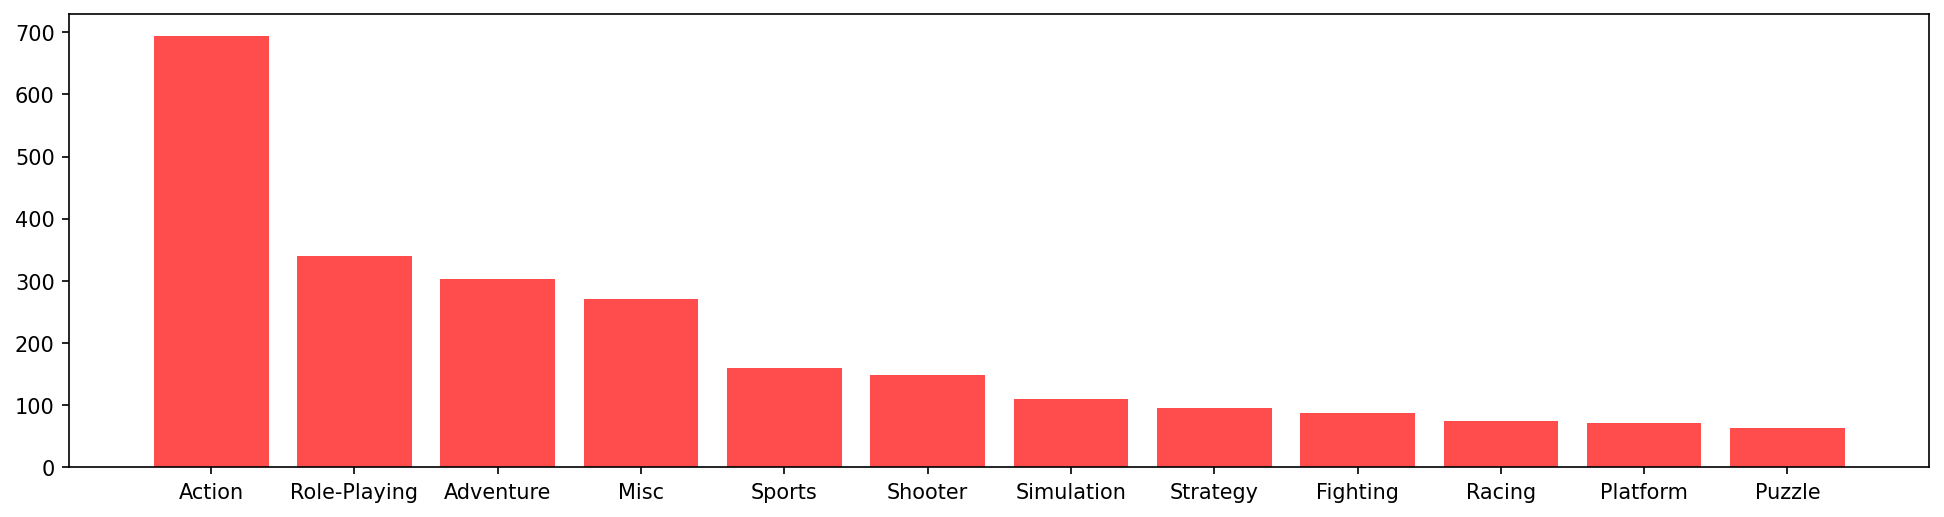

In [92]:
plt.figure(figsize=(16,4),dpi=150)
plt.bar(genre_stats.index, genre_stats.values, color='red', alpha=0.7)

Игры жанра action впереди со значительным отрывом. За ними идут RPG и игры жанра Adventure.

# Шаг 4. Портрет пользователя каждого региона

## Самые популярные платформы (топ-5)

In [94]:
na_sales = modern_games.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head()
eu_sales = modern_games.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head()
jp_sales = modern_games.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head()

Text(0.5, 1.0, 'Japan')

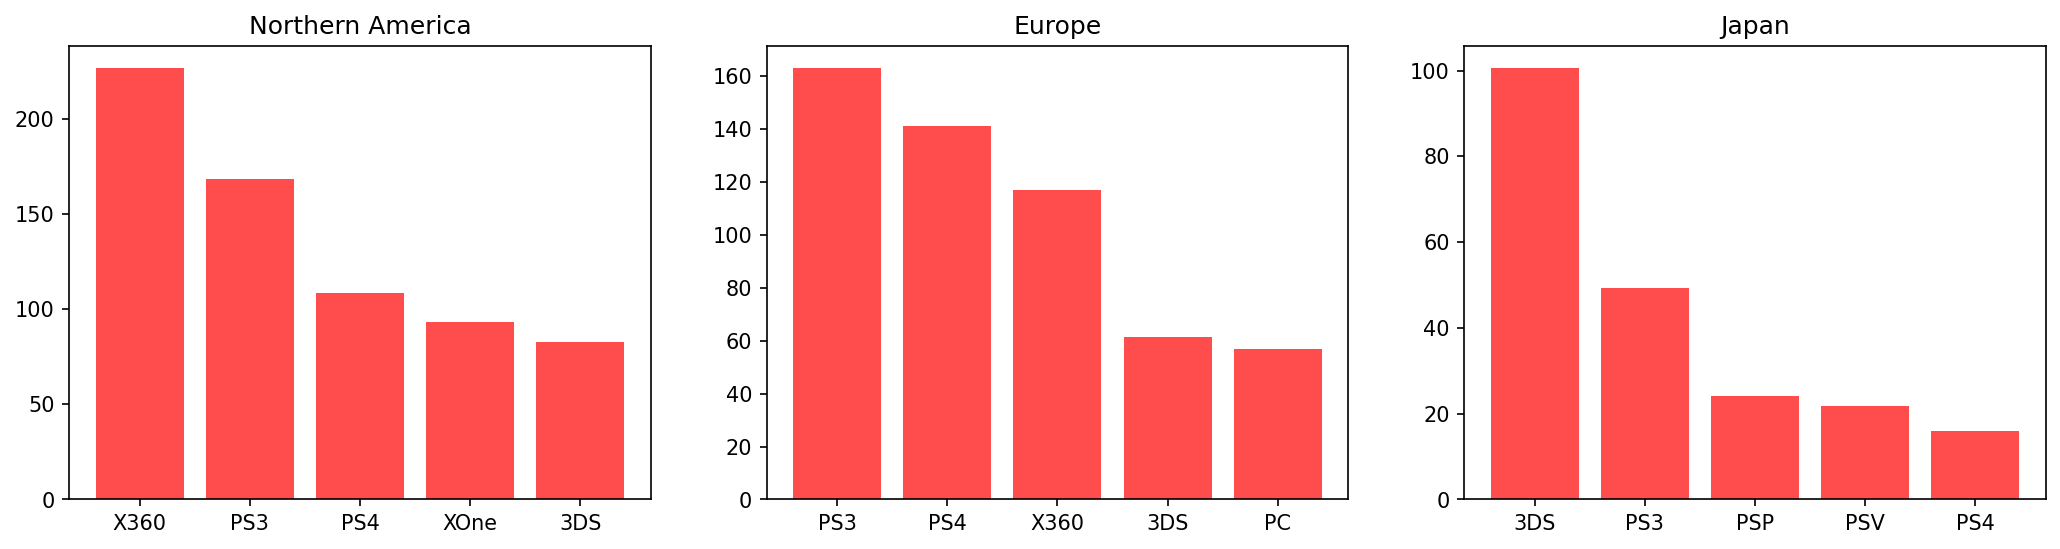

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4), dpi=150)
ax0, ax1,ax2 = axes.flatten()

ax0.bar(na_sales.index, na_sales.values, color='red', alpha=0.7)
ax0.set_title('Northern America')

ax1.bar(eu_sales.index, eu_sales.values, color='red', alpha=0.7)
ax1.set_title('Europe')

ax2.bar(jp_sales.index, jp_sales.values, color='red', alpha=0.7)
ax2.set_title('Japan')

У Японии в топе только отечественное.

## Топ-5 жанров по регионам

In [97]:
na_genre = modern_games.drop_duplicates(
    subset ='name').groupby('genre')['na_sales'].sum().sort_values(ascending=False).head()
eu_genre = modern_games.drop_duplicates(
    subset ='name').groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head()
jp_genre = modern_games.drop_duplicates(
    subset ='name').groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head()

Text(0.5, 1.0, 'Japan')

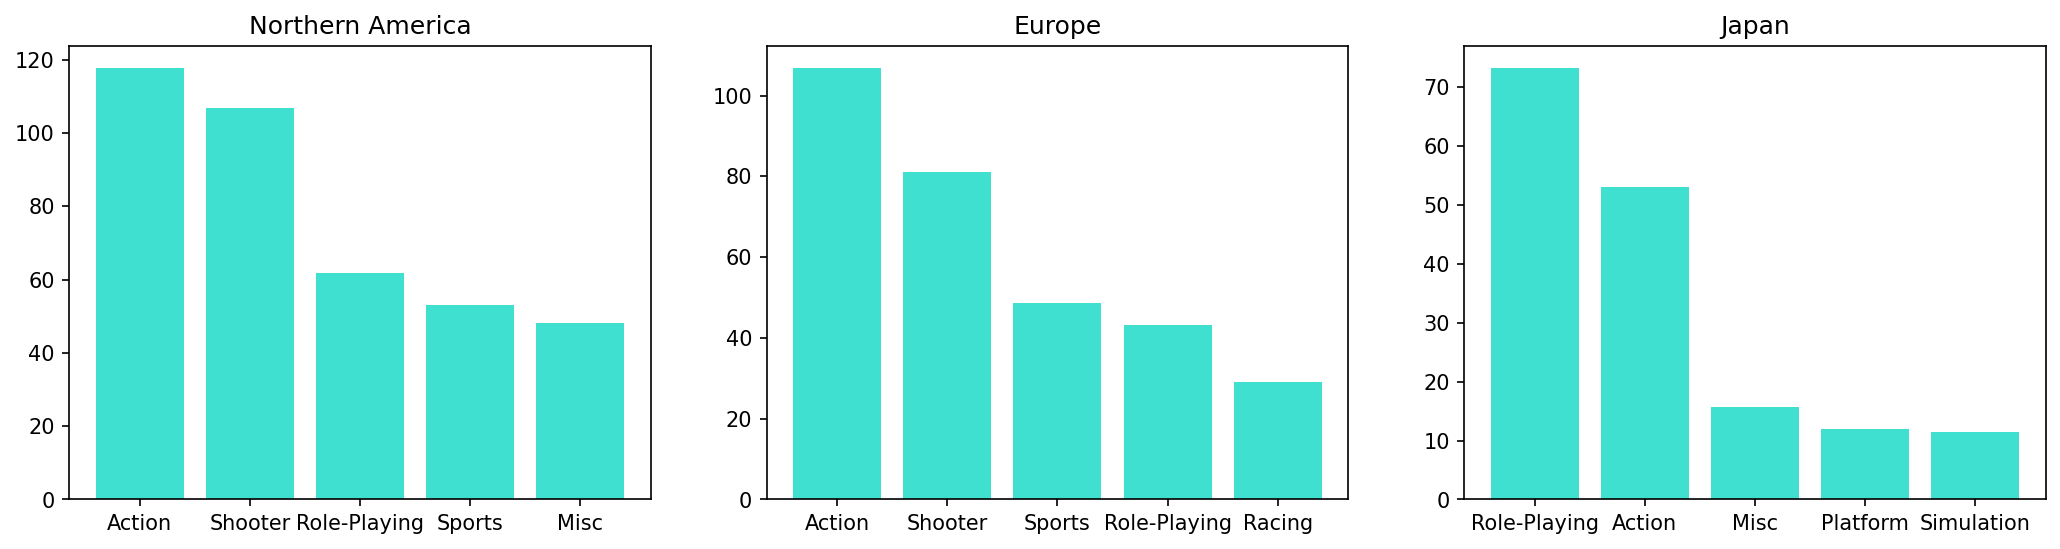

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4), dpi=150)
ax0, ax1,ax2 = axes.flatten()

ax0.bar(na_genre.index, na_genre.values, color='turquoise')
ax0.set_title('Northern America')

ax1.bar(eu_genre.index, eu_genre.values, color='turquoise')
ax1.set_title('Europe')

ax2.bar(jp_genre.index, jp_genre.values, color='turquoise')
ax2.set_title('Japan')

Япония опять отличилась – там на первом месте стоят RPG, а шутеров в топе нет

## Влияние возрастного рейтинга на продажи

In [100]:
esrb_stats = modern_games[['na_sales','eu_sales','jp_sales', 'rating']].query('rating.notna()')
na_esrb = esrb_stats.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
eu_esrb = esrb_stats.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
jp_esrb = esrb_stats.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

Text(0.5, 1.0, 'Japan')

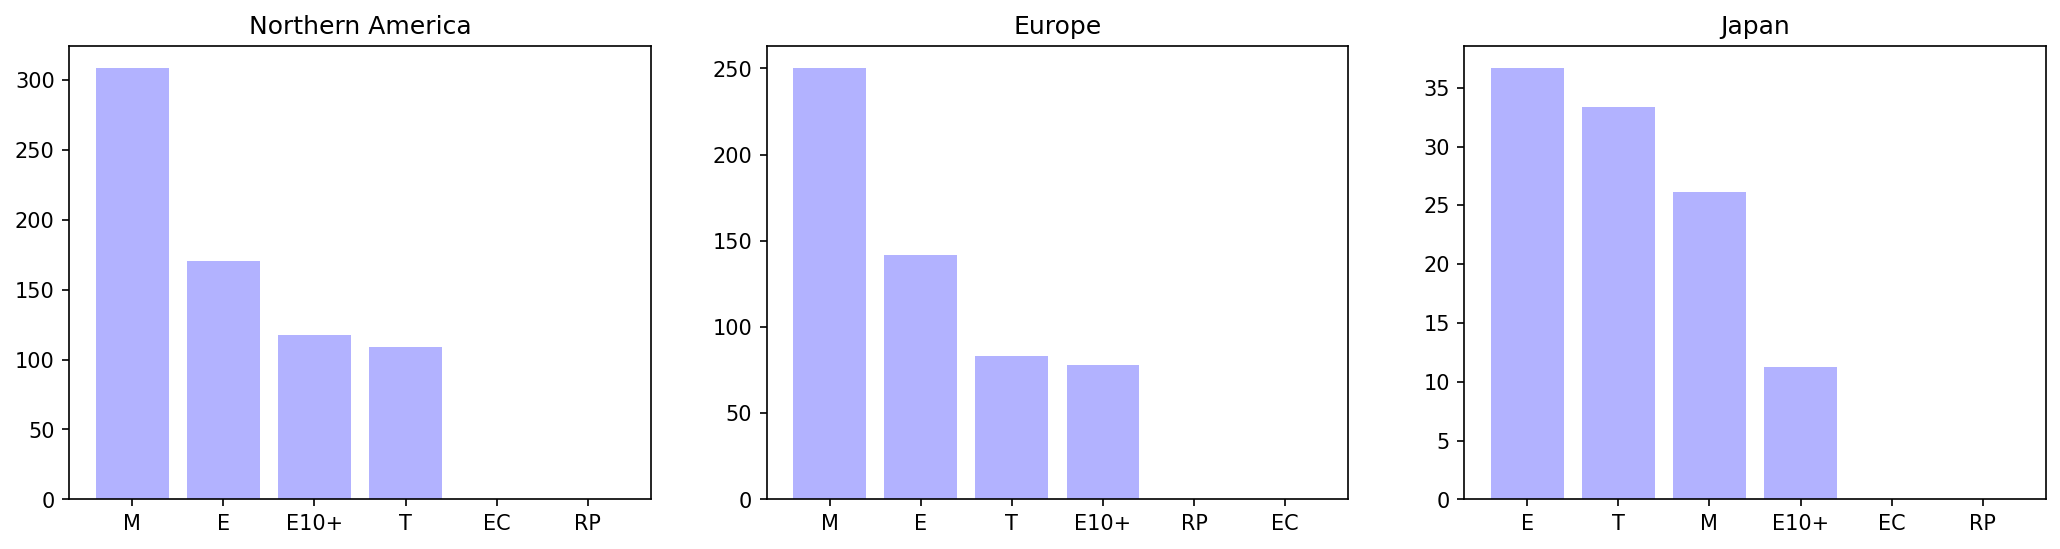

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4), dpi=150)
ax0, ax1,ax2 = axes.flatten()

ax0.bar(na_esrb.index,na_esrb.values, color='blue', alpha=0.3)
ax0.set_title('Northern America')

ax1.bar(eu_esrb.index,eu_esrb.values, color='blue', alpha=0.3)
ax1.set_title('Europe')

ax2.bar(jp_esrb.index,jp_esrb.values, color='blue', alpha=0.3)
ax2.set_title('Japan')

На рынках Северной Америки и Европы картина очень схожая: лучше всего продаются игры с рейтингом M (17+), затем идут игры с рейтингом E (0+) и T/E10+ (10+/13+).

В Японии же игры с рейтингом M гораздно менее поопулярны и стоят только на третьем месте, опережая E10+. На первом месте игры 0+, а на втором – игры для подростков (13+).

# Шаг 5. Проверка гипотез.

In [106]:
alpha = .01

results = st.ttest_ind(modern_games.query('platform == "X360"')['user_score'], 
                       modern_games.query('platform == "PC"')['user_score'], nan_policy='omit')

print('p-value =',results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value = 0.32838226596948605
Не получилось отвергнуть нулевую гипотезу


Cредние пользовательские рейтинги платформ Xbox 360 и PC равны. 

In [109]:
alpha = .01

for platf in platforms_list:

    results = st.ttest_ind(modern_games.query('platform == @platf')['user_score'], 
                           modern_games.query('platform == "PC"')['user_score'])

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу.\nCредние пользовательские рейтинги платформ {} и PC равны.\n".format(platf))

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ PS3 и PC равны.

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ X360 и PC равны.

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ PS4 и PC равны.

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ 3DS и PC равны.

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ XOne и PC равны.

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ PC и PC равны.

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ Wii и PC равны.

Не получилось отвергнуть нулевую гипотезу.
Cредние пользовательские рейтинги платформ WiiU и PC равны.



Судя по всему, пользовательские рейтинги не зависят от платформы.

In [111]:
alpha = .01

results = st.ttest_ind(modern_games.query('genre == "Action"')['user_score'], modern_games.query('genre == "Sports"')['user_score'])

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Средние пользовательские рейтинги жанров Action и Sports равны. 

# ВЫВОД

Медианный цикл жизни платформы составляет 9,5 лет, поэтому платформы, актуальные для 2016 года, – это PlayStation 3, XBox 360, PlayStation 4, Nintendo 3DS, XBox One, Nintendo Wii, Nintendo Wii U и PC.

На данный момент XBox One и PlayStation 4 являются самыми привлекательными; они будут находится на пике популярности в этом и следующем годах. PlayStation 3, XBox 360 и Nintendo 3DS уже доживают своё и делать на них ставку точно не стоит.

Продажи по платформам PlayStation 3, PlayStation 4, XBox 360 и XBox One почти одинаковые. Продажи по консолям Nintendo значительно меньше, а самая неприбыльная платформа, если судить по предоставленным данным, – это ПК.

Важно заметить, что внутриигровые покупки в исследовании не участвовали.

Влияние оценки пользователей на продажи игры минимальное, а корелляция продаж с оценками критиков хоть и есть, но несильная.

Пользователские оценки не отличаются от платформы к платформе.

Самый популярный жанр на глобальном рынке – это Action. На рынках Европы и Америки он также стоит на первом месте, опережая шутеры, RPG и спортивные игры. В Японии же на первом месте стоит жанр RPG, за ним – Action и жанр "другие".

Выпуская игру для Европы и Северной Америки стоит учитывать, что игры с возрастным рейтингом M (17+) пользуются там наибольшей популярностью – их продажи почти в два раза превышают продажи игр с рейтигом E (0+).

В Японии картина другая – там популярнее игры E (0+) и T (17+).